In [1]:
import gym
from gym_minigrid.wrappers import ImgObsWrapper
from mini_behavior.utils.wrappers import MiniBHFullyObsWrapper
from mini_behavior.register import register
from algorithms.APT_PPO import APT_PPO
import mini_behavior
from stable_baselines3 import PPO
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
import torch.nn as nn
import torch
from env_wrapper import CustomObservationWrapper
import argparse
from mini_behavior.roomgrid import *

class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

TASK = 'MultiToy'
PARTIAL_OBS = True
ROOM_SIZE = 16
MAX_STEPS = 1000
TOTAL_TIMESTEPS = 1e5
DENSE_REWARD = False
POLICY_TYPE = 'CnnPolicy'
NUM_ENVS = 8
NUM_STEPS = 125
env_name = f"MiniGrid-{TASK}-{ROOM_SIZE}x{ROOM_SIZE}-N2-v0"

In [2]:
env_kwargs = {"room_size": ROOM_SIZE, "max_steps": MAX_STEPS, "exploration_type": "ATP"}
def get_single_env() -> gym.Env:
    '''
    policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128)
)
    '''

    # Env wrapping
    env_name = f"MiniGrid-{TASK}-{ROOM_SIZE}x{ROOM_SIZE}-N2-v0"

    kwargs = {"room_size": ROOM_SIZE, "max_steps": MAX_STEPS}


    register(
        id=env_name,
        entry_point=f'mini_behavior.envs:{TASK}Env',
        kwargs=kwargs
    )

    '''
    config = {
        "policy_type": POLICY_TYPE,
        "total_timesteps": TOTAL_TIMESTEPS,
        "env_name": env_name,
    }
    '''
    
    env = gym.make(env_name)
    env = CustomObservationWrapper(env)

    return env


def init_env(num_envs: int):

    env_fns = [lambda: get_single_env() for _ in range(num_envs)]
    if num_envs == 1:
        return DummyVecEnv(env_fns)
    else:
        return SubprocVecEnv(env_fns)
    




In [3]:
env = get_single_env()


=== Observation Space ===
Shape: (59,)
Type: float32


In [27]:
print(env.gen_obs())
objs_dict = {}
for obj_type in env.objs.values():
    for obj in obj_type:
        states_dict = {}
        for state_value in obj.states:
            if not isinstance(obj.states[state_value], RelativeObjectState):
                state = obj.states[state_value].get_value(env)
                states_dict[state_value] = state
        objs_dict[obj.name] = states_dict
print(objs_dict)
                

[5. 6. 0. 3. 3. 0. 0. 0. 0. 1. 7. 0. 0. 0. 3. 2. 0. 0. 0. 4. 1. 0. 0. 0.
 0. 0. 6. 4. 1. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 8. 6. 1. 0. 0. 0. 3.
 5. 0. 0. 0. 2. 6. 0. 0. 0. 0. 0.]
{'alligator_busy_box_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False, 'toggled': False}, 'ball_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False}, 'beach_ball_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False}, 'music_toy_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False, 'noise': False, 'toggled': False}, 'farm_toy_0': {'infovofrobot': True, 'inhandofrobot': False, 'inreachofrobot': False, 'popup': False, 'toggled': False}, 'piggie_bank_0': {'infovofrobot': False, 'inhandofrobot': False, 'inreachofrobot': False, 'noise': False, 'open': False, 'toggled': False}, 'rattle_0': {'infovofrobot': True, 'inhandofrobot': False, 'inreachofrobot': False, 'noise': False}, 'red_spiky_ball_0': {'infovofrobot': False,

In [25]:
from mini_behavior.utils.states_base import RelativeObjectState
print(env.objs)
for obj_type in env.objs.values():
    for obj in obj_type:
        print(obj.name, end = '\n\n')
        for state_value in obj.states:
            if not isinstance(obj.states[state_value], RelativeObjectState):
                state = obj.states[state_value].get_value(env)
                print(str(state_value) + ": " + str(state))

exploration_dict = {obj.name: {} for obj_type in env.objs.values() for obj in obj_type}
for dict, obj in zip(exploration_dict.values(), list(obj for obj_type in env.objs.values() for obj in obj_type)):
    for state_value in obj.states:
        if not isinstance(obj.states[state_value], RelativeObjectState):
            dict[state_value] = 0
print(exploration_dict)


{'alligator_busy_box': [<mini_behavior.utils.objects_base.WorldObj object at 0x1059ae8e0>], 'ball': [<mini_behavior.utils.objects_base.WorldObj object at 0x1059ae610>], 'beach_ball': [<mini_behavior.utils.objects_base.WorldObj object at 0x1059aefa0>], 'music_toy': [<mini_behavior.utils.objects_base.WorldObj object at 0x105937670>], 'farm_toy': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f78fe20>], 'piggie_bank': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f78ffd0>], 'rattle': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f78fcd0>], 'red_spiky_ball': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f7915e0>], 'winnie_cabinet': [<mini_behavior.utils.objects_base.WorldObj object at 0x14f791820>]}
alligator_busy_box_0

infovofrobot: False
inhandofrobot: False
inreachofrobot: False
toggled: False
ball_0

infovofrobot: False
inhandofrobot: False
inreachofrobot: False
beach_ball_0

infovofrobot: False
inhandofrobot: False
inreachofrobot: False


In [ ]:
env = init_env(NUM_ENVS)
    
print('begin training')
# Policy training
model = APT_PPO(env, num_envs=NUM_ENVS, total_timesteps = TOTAL_TIMESTEPS, num_steps=NUM_STEPS, save_freq = 10)

model.train()

In [4]:
import os

# Define the directory path
save_dir = "models/ATP_PPO_Trial"

# Check if the directory exists, and if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(f"{save_dir}/{env_name}", env_kwargs= env_kwargs)

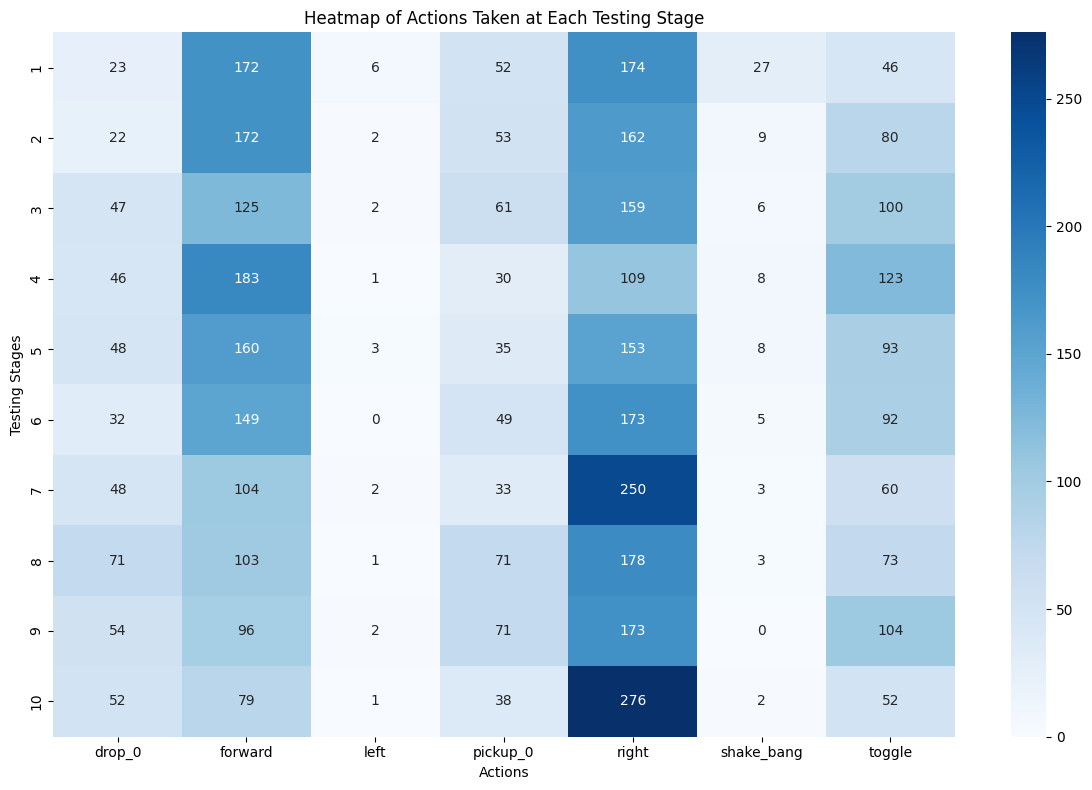

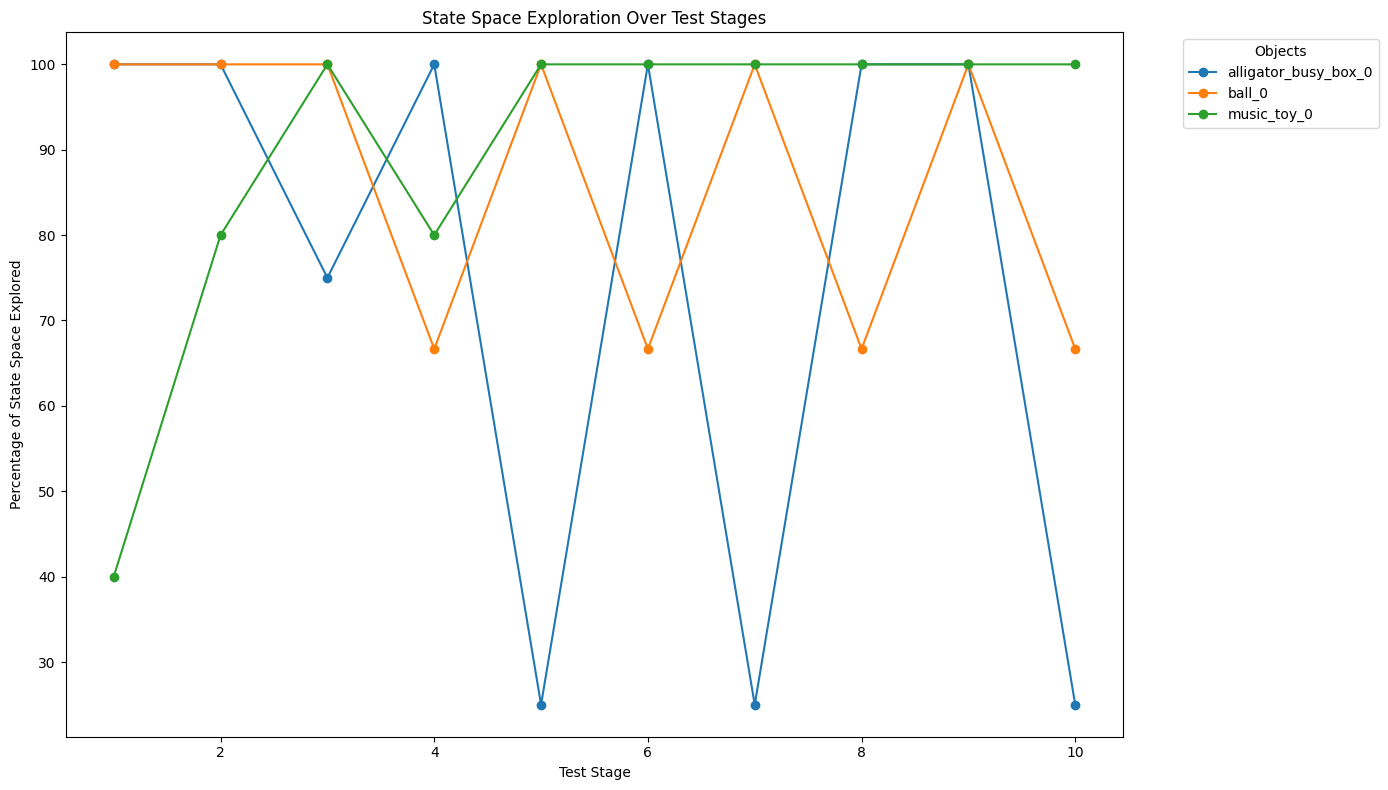

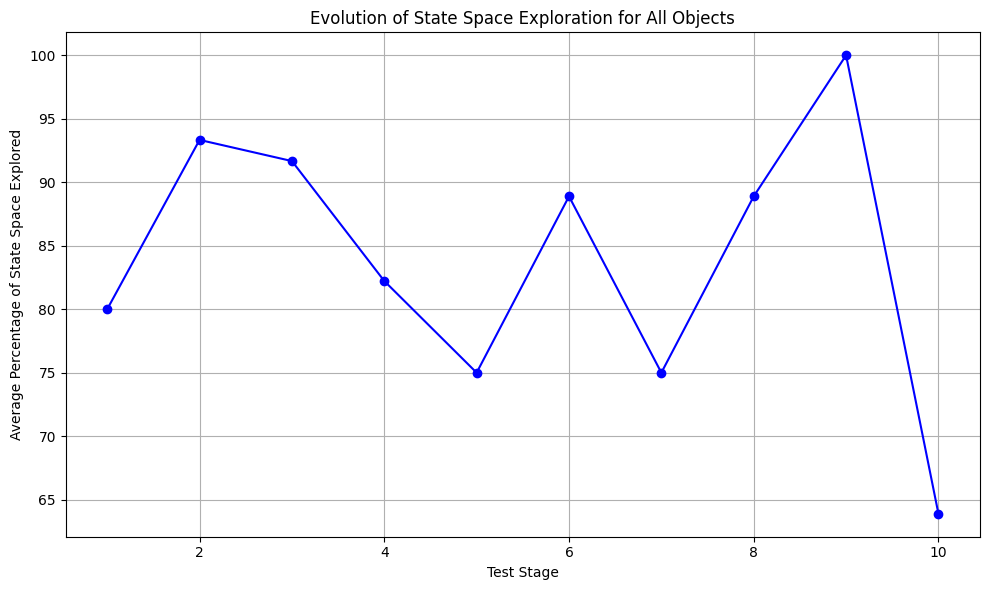

In [22]:


checkpoint = torch.load(
    "models/APT_PPO_Test_NoiseTest/MiniGrid-Test-8x8-N2-v0", 
)

In [23]:
print(checkpoint.keys())

dict_keys(['env_kwargs', 'model_saves', 'final_model_state_dict', 'final_optimizer_state_dict', 'learning_rate', 'total_timesteps', 'num_envs', 'num_steps', 'curiosity_rewards', 'actions', 'observations', 'exploration_percentages', 'test_actions', 'test_action_heat_map', 'state_exploration_graph_per_obj', 'state_exploration_all_objs', 'test_exploration_state_occurrences'])


In [24]:
state_occ = checkpoint['test_exploration_state_occurrences']

In [25]:
print(state_occ[0])

{'alligator_busy_box_0': {'infovofrobot': {'True': 222, 'False': 280}, 'inhandofrobot': {'True': 14, 'False': 488}, 'inreachofrobot': {'True': 35, 'False': 467}, 'toggled': {'True': 31, 'False': 471}}, 'ball_0': {'infovofrobot': {'True': 224, 'False': 278}, 'inhandofrobot': {'True': 86, 'False': 416}, 'inreachofrobot': {'True': 105, 'False': 397}}, 'music_toy_0': {'infovofrobot': {'True': 233, 'False': 269}, 'inhandofrobot': {'True': 0, 'False': 502}, 'inreachofrobot': {'True': 3, 'False': 499}, 'noise': {'True': 0, 'False': 502}, 'toggled': {'True': 0, 'False': 502}}}


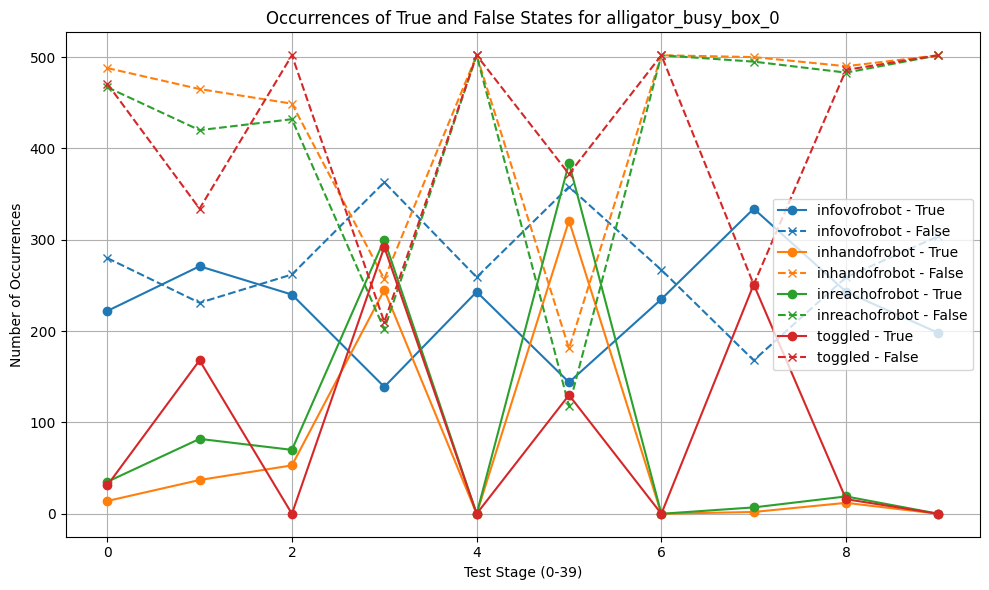

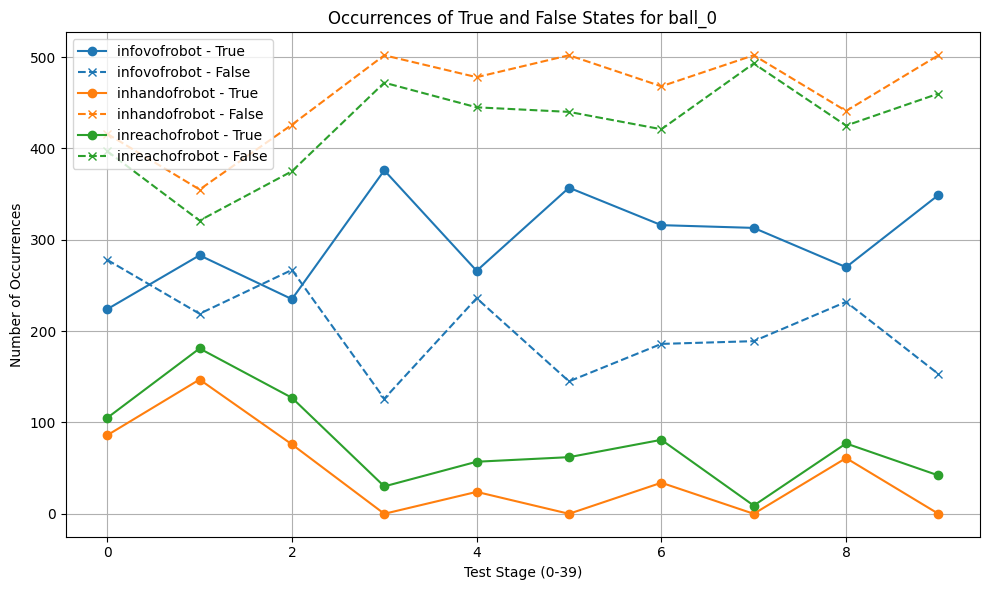

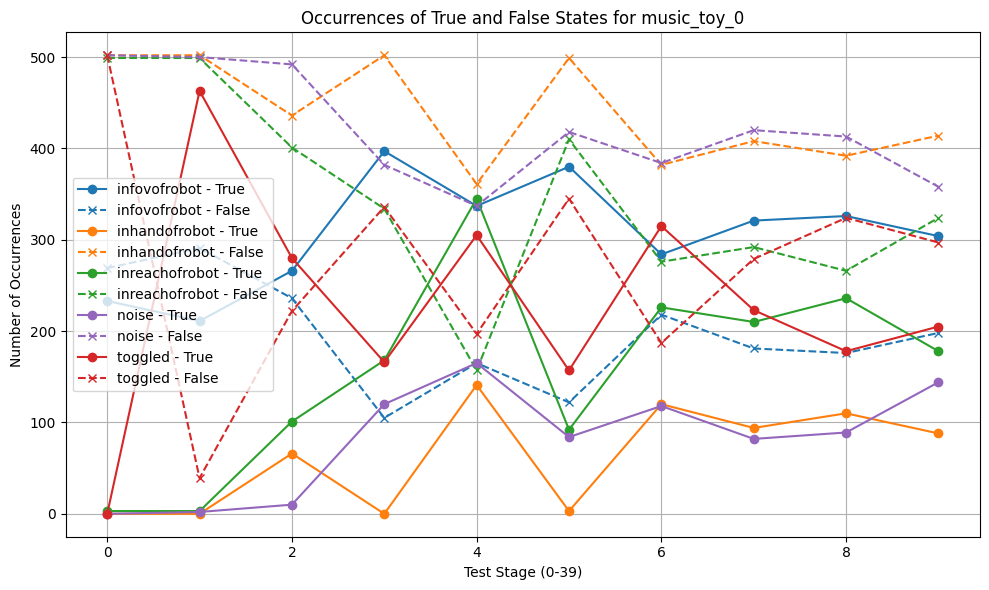

In [26]:
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# Define a color palette for consistent state coloring
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap (e.g., 'tab10')
state_colors = {}  # A dictionary to map states to colors

# Aggregate data for plotting
objects_states = defaultdict(lambda: defaultdict(lambda: {"True": [], "False": []}))

# Iterate over each test stage (element in state_occ)
for stage, timestep_dict in enumerate(state_occ):
    for obj_name, states in timestep_dict.items():
        for state_name, counts in states.items():
            # Assign a unique color to each state if not already assigned
            if state_name not in state_colors:
                state_colors[state_name] = next(colors)
            # Append the counts of True and False to the corresponding lists
            objects_states[obj_name][state_name]["True"].append(counts.get("True", 0))
            objects_states[obj_name][state_name]["False"].append(counts.get("False", 0))

# Create plots for each object
for obj_name, states in objects_states.items():
    plt.figure(figsize=(10, 6))  # Create a new figure for each object
    for state_name, values in states.items():
        # Use the same color for True and False of the same state
        color = state_colors[state_name]
        plt.plot(range(len(values["True"])), values["True"], label=f'{state_name} - True', marker='o', color=color)
        plt.plot(range(len(values["False"])), values["False"], label=f'{state_name} - False', marker='x', color=color, linestyle='--')
    
    # Add labels, title, legend, etc.
    plt.title(f"Occurrences of True and False States for {obj_name}")
    plt.xlabel("Test Stage (0-39)")
    plt.ylabel("Number of Occurrences")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()


In [23]:
hd = 0

#### ONLY IF USING OBJECT STATES ONLY ####
start_idx = 3  # Initial start index for obs1 and obs2

for obj_len in pattern:
    # Skip the two position elements for each object
    state_start = start_idx + 2
    
    # Loop through the object state entries
    for obj1 in sample_obs[state_start: state_start + obj_len]:
        print(obj_len)
        print(obj1)                     
        

    start_idx += obj_len  + 2


4
tensor(0.)
4
tensor(0.)
4
tensor(0.)
4
tensor(0.)
3
tensor(0.)
3
tensor(0.)
3
tensor(0.)
3
tensor(0.)
3
tensor(0.)
3
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
6
tensor(1.)
6
tensor(0.)
6
tensor(0.)
6
tensor(0.)
6
tensor(0.)
6
tensor(0.)
4
tensor(0.)
4
tensor(0.)
4
tensor(0.)
4
tensor(0.)
3
tensor(0.)
3
tensor(0.)
3
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)
5
tensor(0.)


{'alligator_busy_box_0': [100.0, 87.5, 62.5, 62.5, 87.5, 62.5, 87.5, 87.5, 62.5, 62.5], 'ball_0': [100.0, 83.33, 100.0, 83.33, 66.67, 66.67, 66.67, 100.0, 83.33, 66.67], 'beach_ball_0': [66.67, 83.33, 100.0, 50.0, 100.0, 83.33, 100.0, 100.0, 83.33, 100.0], 'music_toy_0': [70.0, 60.0, 80.0, 60.0, 70.0, 70.0, 70.0, 70.0, 80.0, 70.0], 'farm_toy_0': [60.0, 70.0, 60.0, 50.0, 90.0, 60.0, 60.0, 80.0, 60.0, 80.0], 'piggie_bank_0': [75.0, 58.33, 58.33, 58.33, 58.33, 66.67, 58.33, 58.33, 66.67, 75.0], 'rattle_0': [62.5, 62.5, 62.5, 62.5, 62.5, 75.0, 62.5, 62.5, 87.5, 75.0], 'red_spiky_ball_0': [83.33, 100.0, 83.33, 83.33, 100.0, 66.67, 83.33, 83.33, 66.67, 66.67], 'winnie_cabinet_0': [80.0, 80.0, 70.0, 60.0, 80.0, 80.0, 70.0, 80.0, 80.0, 80.0]}


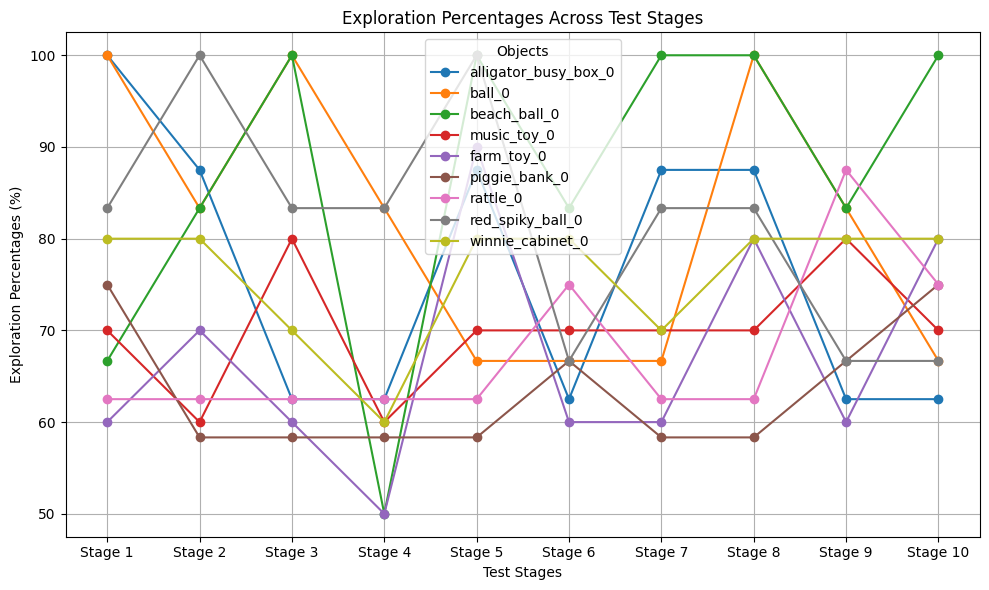

In [81]:
import matplotlib.pyplot as plt

exploration_data = checkpoint['exploration_percentages']
objects = list(exploration_data[0].keys())  # Extract object names

# Extract exploration percentages
exploration_percentages = {obj: [] for obj in objects}
for stage in exploration_data:
    for obj in objects:
        exploration_percentages[obj].append(float(stage[obj]))

print(exploration_percentages)

# Create the plot
plt.figure(figsize=(10, 6))
for obj, percentages in exploration_percentages.items():
    plt.plot(percentages, marker="o", label=obj)

# Customize plot
plt.title("Exploration Percentages Across Test Stages")
plt.xlabel("Test Stages")
plt.ylabel("Exploration Percentages (%)")
plt.xticks(range(len(exploration_data)), [f"Stage {i+1}" for i in range(len(exploration_data))])
plt.legend(title="Objects")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
queue = [1,2,3,4]
print(queue.pop(0))
print(queue)

1
[2, 3, 4]


In [25]:

from IPython.display import display

actions = checkpoint['actions']
rewards = checkpoint['curiosity_rewards']
def all_tensors_same_length(tensor_list):
    lengths = [t.size(0) for t in tensor_list]  # Get the length of each tensor
    return all(length == lengths[0] for length in lengths)

# Usage
if all_tensors_same_length(actions):
    print("All tensors have the same length.")
else:
    print("Tensors have different lengths.")
actions = [tensor.to(torch.int64).flatten() for tensor in actions]
print(actions[2])


All tensors have the same length.
tensor([2, 0, 4, 6, 6, 6, 6, 5, 1, 4, 1, 1, 3, 6, 4, 0, 3, 0, 1, 1, 2, 3, 0, 5,
        5, 3, 3, 3, 2, 5, 2, 2, 2, 0, 3, 2, 6, 0, 2, 6, 5, 1, 4, 3, 3, 2, 2, 0,
        6, 3, 0, 6, 3, 2, 5, 4, 0, 1, 5, 0, 5, 2, 3, 4, 4, 0, 1, 1, 0, 5, 1, 3,
        5, 3, 0, 4, 1, 3, 4, 0, 4, 3, 0, 4, 1, 5, 4, 1, 1, 0, 3, 3, 4, 5, 4, 0,
        5, 6, 2, 3, 0, 5, 4, 0, 3, 5, 3, 0, 4, 6, 3, 2, 3, 6, 4, 1, 5, 1, 6, 5,
        5, 2, 3, 4, 3, 4, 2, 4, 0, 5, 2, 6, 2, 2, 0, 0, 4, 4, 0, 6, 4, 1, 0, 6,
        4, 4, 1, 6, 3, 3, 6, 4, 4, 6, 6, 4, 2, 3, 3, 5, 1, 0, 2, 1, 5, 0, 2, 6,
        6, 3, 5, 4, 3, 2, 4, 3, 1, 1, 6, 2, 0, 6, 0, 0, 4, 5, 1, 2, 0, 6, 5, 4,
        3, 0, 4, 4, 4, 0, 4, 5, 5, 6, 0, 6, 4, 2, 1, 0, 6, 0, 5, 6, 4, 6, 5, 2,
        6, 3, 6, 2, 3, 1, 1, 2, 2, 3, 1, 2, 5, 3, 1, 4, 4, 4, 5, 5, 1, 4, 2, 1,
        4, 0, 1, 2, 2, 5, 6, 6, 4, 1, 0, 3, 5, 6, 4, 5, 1, 3, 4, 2, 0, 4, 1, 5,
        0, 5, 6, 1, 2, 3, 5, 6, 5, 4, 3, 5, 3, 0, 5, 2, 6, 3, 0, 2, 0, 3, 3, 6,
      

In [7]:

unique_numbers, counts = torch.unique(actions[970], return_counts=True)

# Print the results
for i,j in zip(unique_numbers, counts):
    print(i,j)

tensor(0.) tensor(407)
tensor(2.) tensor(591)
tensor(5.) tensor(1)
tensor(6.) tensor(1)


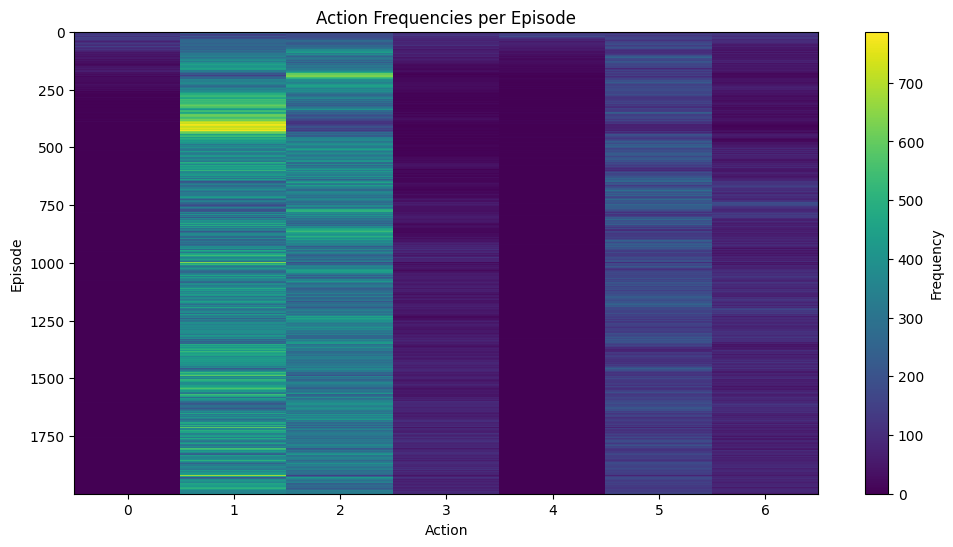

In [27]:
import matplotlib.pyplot as plt
# Find the maximum value to determine the heatmap's size

max_value = max(int(torch.max(tensor)) for tensor in actions)

# Create a frequency matrix where rows are episodes and columns are possible actions
heatmap_data = []
for tensor in actions:
    counts = torch.bincount(tensor, minlength=max_value + 1)
    heatmap_data.append(counts.numpy())

# Convert to a 2D NumPy array for visualization
heatmap_data = np.array(heatmap_data)

# Create the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Frequency')
plt.xlabel('Action')
plt.ylabel('Episode')
plt.title('Action Frequencies per Episode')
plt.show()

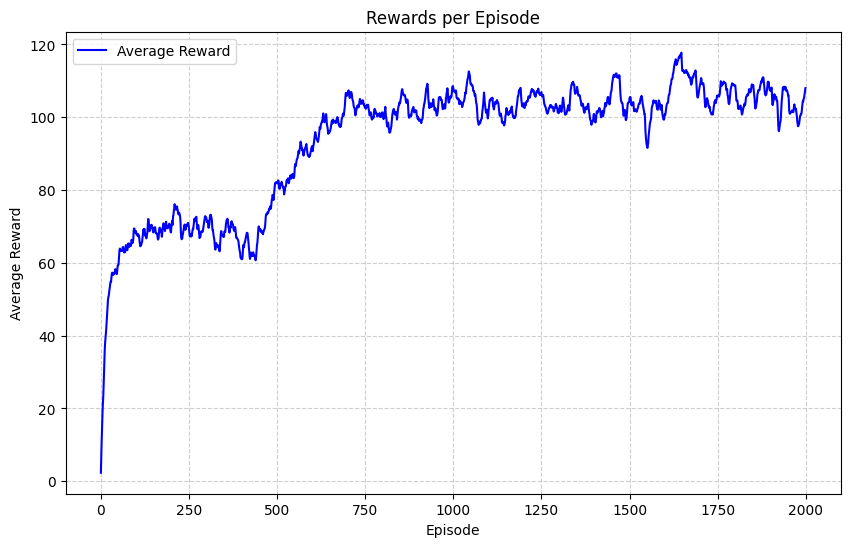

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(rewards, linestyle='-', color='blue', label='Average Reward')

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Rewards per Episode')
plt.legend()

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

In [84]:
mylist = [2,4,6]
myiter = iter(mylist)
print(next(myiter))

2


In [87]:
print(next(myiter))

StopIteration: 

In [41]:
support_cache = supports(armies)

In [42]:
print(support_cache)

{'B': 1, 'C': 1, 'D': 1}


In [13]:
from numpy import linalg as LA
p1, p2 = np.array([0, 0]), np.array([4, 4])
dp = LA.norm((p1 - p2))
print(np.sqrt(32))
print(dp)

5.656854249492381
5.656854249492381


In [32]:
test_dict = {"one": 1, "two": 2}

for i,j in zip(test_dict.keys(), test_dict.values()):
    print(i,j)

one 1
two 2


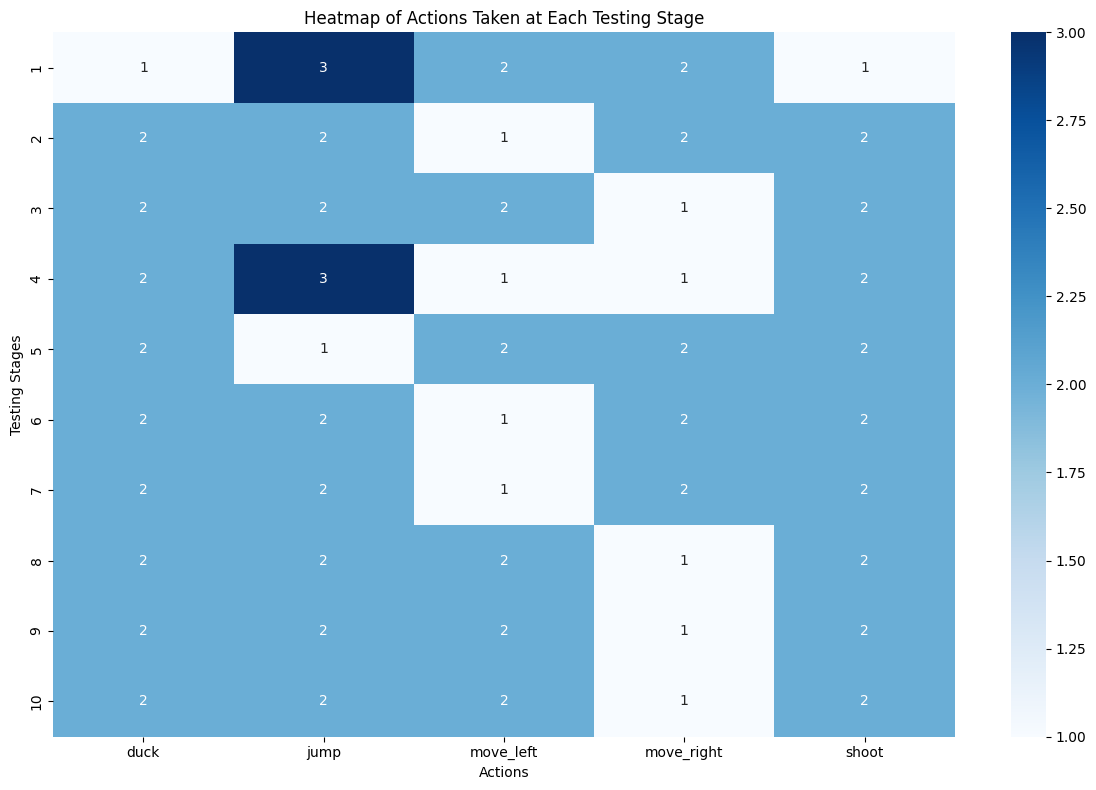

In [46]:
test_actions = [
    ['move_left', 'move_right', 'jump', 'duck', 'move_left', 'jump', 'shoot', 'jump', 'move_right'],  # Stage 1
    ['move_right', 'duck', 'jump', 'jump', 'move_left', 'shoot', 'duck', 'move_right', 'shoot'],      # Stage 2
    ['move_left', 'move_right', 'shoot', 'duck', 'duck', 'jump', 'move_left', 'jump', 'shoot'],      # Stage 3
    ['jump', 'jump', 'move_left', 'move_right', 'shoot', 'shoot', 'duck', 'duck', 'jump'],           # Stage 4
    ['move_left', 'move_right', 'shoot', 'duck', 'jump', 'move_right', 'move_left', 'duck', 'shoot'],# Stage 5
    ['duck', 'move_right', 'move_right', 'jump', 'shoot', 'move_left', 'jump', 'shoot', 'duck'],     # Stage 6
    ['jump', 'move_left', 'shoot', 'duck', 'jump', 'move_right', 'duck', 'move_right', 'shoot'],     # Stage 7
    ['move_left', 'duck', 'jump', 'move_right', 'shoot', 'jump', 'move_left', 'shoot', 'duck'],      # Stage 8
    ['shoot', 'move_right', 'duck', 'move_left', 'jump', 'shoot', 'duck', 'move_left', 'jump'],      # Stage 9
    ['jump', 'shoot', 'duck', 'move_left', 'move_right', 'move_left', 'jump', 'shoot', 'duck']       # Stage 10
]


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame of action counts per stage
unique_actions = sorted(set(action for actions in test_actions for action in actions))
data = pd.DataFrame(0, index=range(1, len(test_actions) + 1), columns=unique_actions)

# Populate the DataFrame with counts
for i, actions in enumerate(test_actions):
    for action in actions:
        data.loc[i + 1, action] += 1

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data, annot=True, cmap="Blues", fmt='d', ax=ax)

# Customize the plot
ax.set_xlabel('Actions')
ax.set_ylabel('Testing Stages')
ax.set_title('Heatmap of Actions Taken at Each Testing Stage')

plt.tight_layout()
plt.show()

